In [1]:
import pandas as pd
import numpy as np
from grouprecommender import GroupRecommender

Using TensorFlow backend.


# Loading the Dataset

The last.fm dataset was extracted from http://www.dtic.upf.edu/~ocelma/MusicRecommendationDataset/lastfm-1K.html and contains  information about the listening habits of almost 1000 users listening to almost a million songs. Each row represents contains information about one song listened by one user at a certain time. Its columns are:

* user_id: the identification of the user that listened to the song.
* timestamp: when was the song listend to.
* artist_id: the identification of the artist performing the song.
* artist_name: the corresponding name of said artist.
* track_id: the identification of the song that was listened.
* track_name: the name of said song.

Here we read the dataset into a pandas dataframe. Some of the columns were poorly formatted and broke the reading process. As they were just 9 out of millions, we considered it safe to just skip them and not include them on the dataframe.

In [2]:
poorly_formatted_rows = [2120259, 2446317, 11141080, 11152098, 11152401, 11882086, 12902538, 12935043, 17589538]
df = pd.read_csv('lastfm_data/userid-timestamp-artid-artname-traid-traname.tsv', header=None, skiprows=poorly_formatted_rows, sep='\t')
df.columns = ['user_id', 'timestamp', 'artist_id', 'artist_name', 'track_id', 'track_name']
df.dropna(inplace=True)

# Group Recommendations

The group recommender object is created here. It takes as parameters:

* utility_matrix: The utility matrix derived from the above dataset and stored in a pickle format. It has a row for each song and a column for each user. Each entry represents how many times the user in the columns listend to the track in the row. As most tracks haven't been listened by each user, this matrix is sparse and represented in an appropriate format.
* dataset: the dataset that generated the utility matrix.
* algo_path: path to the pickled ALS model that makes single user recommendations.
* embedding_model_path: the item2vec model which takes a track id and maps it into an embedding space which captures the "semantics" of the song.
* model_weights_path: the weights of the embedding model.
* embedding_space_path: this is a list where each entry is a song-vector of the chosen vocabulary.
* dicts_path: dictionaries that map from track_ids to inputs to the embedding model and back.

In [3]:
gr = GroupRecommender('models/utility_matrix.pickle',
                      dataset=df,
                      pickled_model_path='models/model.pickle',
                      embedding_model_path='models/embedding_model.yaml',
                      model_weights_path='models/embedding_model.h5',
                      embedding_space_path='models/embedding.npy',
                      dicts_path='models/song_dicts.pickle')

## Obtaining Group Recommendations

Here we use the object to make recommendations. We create a group of $N$ random users from the dataset and make `max_recommendations` recommendations to that group.

There are 3 recommendation methods for the group, but the important one is item2vec.

* The `naive` method will make `max_recommendation` using the ALS algorithm to each user and then get the intersection of these recommendations. It might return no results as there might be no songs in the intersections, so it is usually better to use large values of `max_recommendation` and the number of songs in the result is not predictable.
* the `mean` method uses the ALS to rank all the songs in the dataset for each user and then takes the mean of their scores and selects the ones with the `max_recommendation` highest scores.
* the `item2vec` method uses ALS to make the best recommendation to each user in the group, then uses the item2vec embedding model to convert them to song-vectors in the embedding space. It then takes the median song vector of these songs and finds the `max_recommendation` nearest neighbors to the median vector and then converts them back to track ids.

In [4]:
N = 3
max_recommendations = 10
user_ids = np.random.choice(df['user_id'].unique(), N, replace=False)
playlist = gr.full_recommendation(user_ids, max_recommendations, df, method='item2vec')

In [5]:
print("Recommended Songs for the Group:", user_ids)
for i, track in enumerate(playlist):
    print(str(i) + ')' + track[0] + ' - ' + track[1])

Recommended Songs for the Group: ['user_000213' 'user_000003' 'user_000539']
0)The Who - Baba O'Riley
1)Gorillaz - White Light
2)Oasis - Don'T Look Back In Anger
3)Sly & The Family Stone - If You Want Me To Stay
4)Eddie Vedder - Society
5)The 69 Eyes - Velvet Touch
6)Vitalic - Repair Machines
7)Kelly Clarkson - Gone
8)The Chemical Brothers - Do It Again
9)Uriah Heep - Lady In Black
10)Apocalyptica - Enter Sandman


## Evaluating Recommendations

We use the formula from [4]:
$$
\bar{rank} = \frac{\sum\limits_{u, i}r^t_{u,i}rank_{u,i}}{\sum\limits_{u,i}r^t_{u,i}}
$$
to evaluate the recommendations. In this formula, $u$ is a user, $i$ is an item (i.e. a track), $r^t_{u,i}$ is the entry $u,i$ in the utility matrix, indicating how many times user $u$ listened to track $i$, $rank_{u,i}$ indicates in which ranking the track $i$ falls to the user $u$.

This metric is closer to 0 for better recommendations while 50 represents recommendations as good as random

Another metric taken from the groups is the cosine similarity (1 - cosine distance, i.e. inner product, of their columns in the utility matrix. Then we take the mean cosine similarity between pairs of users in the group. Values close to 1 indicate homogenous groups with similar tastes, while 0 indicates groups that have completely different tastes. Making recommendations for homogenous groups is an easier task.

In [6]:
track_ids = [track.track_id for track in playlist]
playlist_indexes = np.where(np.in1d(df['track_id'].dropna().unique(), track_ids))[0].tolist()
user_indexes = np.where(np.in1d(df['user_id'].dropna().unique(), user_ids))[0].tolist()
eval_score, similarity_score = gr.evaluate(user_indexes, playlist_indexes)
print("Evaluation score: %s, Similarity score: %s" % (str(eval_score), str(similarity_score)))

Evaluation score: 7.57575757576, Similarity score: 0.354014495879


The following functions takes `n_groups` groups of size `group_size` and recommends `n_recommendations` songs for each of them and then evaluates the recommendation score and group similarity and their correlation for each of these groups

In [7]:
def test_groups(df, group_size, group_recommender, n_recommendations=5, n_groups=1000):
    n_users = len(df['user_id'].unique())
    groups = np.random.choice(range(n_users), (n_groups, group_size), replace=True)
    scores = []
    similarities = []
    for i, group in enumerate(groups):
        if i % 10 == 0:
            print("Group of size %d, group number %d" % (group_size, i))
        try:
            track_ids = group_recommender.item2vec_recommendation(group, n_recommendations)
            track_ids = np.where(np.in1d(df['track_id'].dropna().unique(), track_ids))[0].tolist()
            eval_score, sim = group_recommender.evaluate(group, track_ids)
            if eval_score == np.nan:
                eval_score = 50.0
        except:
            eval_score = 50.0
            sim = 0.0
        scores.append(eval_score)
        similarities.append(sim)
    corr = np.correlate(scores, similarities)[0]
    return scores, similarities, corr

And here we parallelize the application of the previous functions for groups from sizes 1 (single users) to 5 and obtain the results for each of these sets of 100 groups.

In [8]:
from joblib import Parallel, delayed

In [9]:
MAX_GROUP_SIZE = 5
results = Parallel(n_jobs=4, backend='threading')(
    delayed(test_groups)(df, i, gr, n_groups=100) for i in range(1, MAX_GROUP_SIZE + 1)
)

Group of size 1, group number 0
Group of size 2, group number 0
Group of size 3, group number 0
Group of size 4, group number 0


/Users/alex/Documents/itc/musicmagal/grouprecommender.py:255: RuntimeWarning: invalid value encountered in double_scalars
  rank = numerator / denominator


Group of size 1, group number 10
Group of size 1, group number 20


/Users/alex/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/alex/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


Group of size 2, group number 10
Group of size 1, group number 30
Group of size 1, group number 40
Group of size 1, group number 50
Group of size 2, group number 20
Group of size 3, group number 10
Group of size 1, group number 60
Group of size 1, group number 70
Group of size 1, group number 80
Group of size 2, group number 30
Group of size 1, group number 90
Group of size 5, group number 0
Group of size 4, group number 10
Group of size 2, group number 40
Group of size 3, group number 20
Group of size 2, group number 50
Group of size 2, group number 60
Group of size 3, group number 30
Group of size 2, group number 70
Group of size 4, group number 20
Group of size 2, group number 80
Group of size 3, group number 40
Group of size 5, group number 10
Group of size 2, group number 90
Group of size 3, group number 50
Group of size 4, group number 30
Group of size 3, group number 60
Group of size 4, group number 40
Group of size 5, group number 20
Group of size 3, group number 70
Group of si

Once the results are obtained, we compute the mean score and mean similarity for each group size.

In [10]:
mean_scores = []
mean_similarities = []
for result in results:
    scores = [x for x in result[0] if ~np.isnan(x)]
    similarities = [x for x in result[1] if ~np.isnan(x)]
    mean_scores.append(np.mean(scores))
    mean_similarities.append(np.mean(similarities))

And finally, we plot these results. Both are plotted against the group sizes.

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

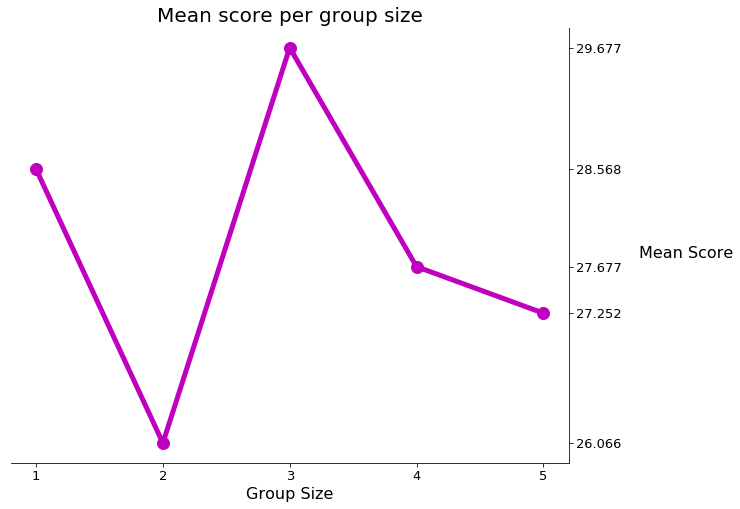

In [12]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(range(1, 6), mean_scores, 'o-', color='m', linewidth=5, markersize=12)
plt.xlabel('Group Size', fontsize=16)
ax.set_ylabel('Mean Score', fontsize=16, rotation=0, ha='right')
ax.yaxis.set_label_coords(1.21, 0.5)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.xticks([1,2,3,4,5])
plt.yticks(mean_scores)
plt.tick_params(labelsize=13)
ax.set_title("Mean score per group size", fontdict={'fontsize': 20})



plt.show()

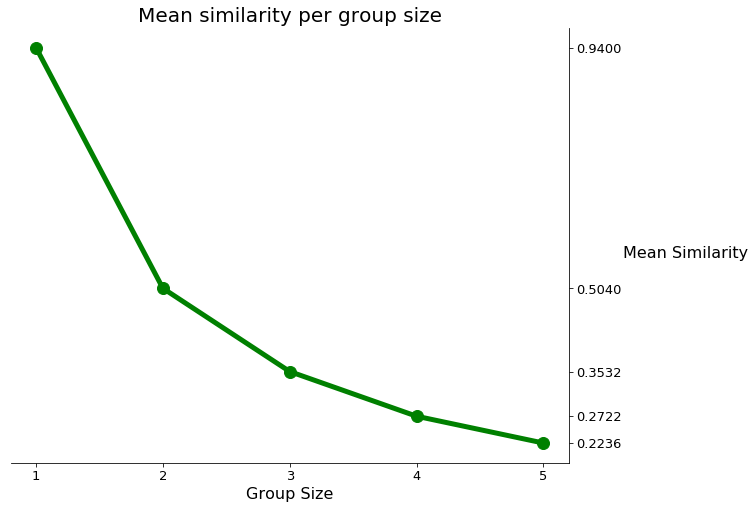

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(range(1, 6), mean_similarities, 'o-', color='g', linewidth=5, markersize=12)
plt.xlabel('Group Size', fontsize=16)
ax.set_ylabel('Mean Similarity', fontsize=16, rotation=0, ha='right')
ax.yaxis.set_label_coords(1.21, 0.5)
ax.spines["top"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
plt.xticks([1,2,3,4,5])
plt.yticks(mean_similarities)
plt.tick_params(labelsize=13)
ax.set_title("Mean similarity per group size", fontdict={'fontsize': 20})
plt.show()


As expected, the group recommendations tend to get worse as the group size becomes larger (which also makes the similarity get lower). The better results for groups of size 3 than for groups of size 2 is unexpected, but probabily an outlier considering that only 100 groups were taken into account to obtain these results.

The results tend to be in the range from 20 to 30, which is not stellar, but is considerably better than random. The approach taken in this project is just a first step into group recommendations and many tweaks and twists can be made to the models and the pipeline.

# References:

[1] Mezei, Zsolt, and Carsten Eickhoff. “Evaluating Music Recommender Systems for Groups.” arXiv preprint arXiv:1707.09790 (2017).

[2] Yoshii, Kazuyoshi, et al. “Hybrid Collaborative and Content-based Music Recommendation Using Probabilistic Model with Latent User Preferences.” ISMIR. Vol. 6. 2006.

[3] Parra, Denis, et al. “Implicit feedback recommendation via implicit-to-explicit ordinal logistic regression mapping.” Proceedings of the CARS-2011 (2011).

[4] Hu, Yifan, Yehuda Koren, and Chris Volinsky. “Collaborative filtering for implicit feedback datasets.” Data Mining, 2008. ICDM’08. Eighth IEEE International Conference on. Ieee, 2008.

[5] Barkan, Oren, and Noam Koenigstein. “Item2vec: neural item embedding for collaborative filtering.” Machine Learning for Signal Processing (MLSP), 2016 IEEE 26th International Workshop on. IEEE, 2016.

[6] Leskovec, Jure, Anand Rajaraman, and Jeffrey David Ullman. Mining of massive datasets. Cambridge university press, 2014.